分析目标
建立预测模型，按日月年预测
分析思路
清洗预处理，分析简单统计指标，数据分层，分析统计指标，建立数据模型

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
# 基本库

有用的数据：地区号，商品编号，大类号，小类号，交易方式，交易价格，交易量

# 数据预处理

In [2]:
# 训练数据data-train
df = pd.read_csv('./示例数据/order_train0.csv')
# df.head(5)

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015/9/2,104,20028,301,405,offline,1005.0,11
1,2015/9/3,102,20354,303,401,offline,1420.0,64
2,2015/9/4,101,20586,306,407,offline,978.0,7
3,2015/9/4,101,20230,306,407,offline,864.0,66
4,2015/9/4,105,21619,306,402,online,274.0,102


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59769 entries, 0 to 59768
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_date         59769 non-null  object 
 1   sales_region_code  59769 non-null  int64  
 2   item_code          59769 non-null  int64  
 3   first_cate_code    59769 non-null  int64  
 4   second_cate_code   59769 non-null  int64  
 5   sales_chan_name    59769 non-null  object 
 6   item_price         59769 non-null  float64
 7   ord_qty            59769 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 3.6+ MB


In [18]:
df['order_date'] = pd.to_datetime(df['order_date'])

## —————交易价格和交易量的关系———————

## 1.先进行描述性分析

count    59769.000000
mean      1074.334474
std        966.881714
min          1.000000
25%        597.000000
50%        880.280000
75%       1291.000000
max      47911.000000
Name: item_price, dtype: float64
count    59769.000000
mean        91.443139
std        195.407986
min          1.000000
25%         10.000000
50%         29.000000
75%        101.000000
max      12480.000000
Name: ord_qty, dtype: float64


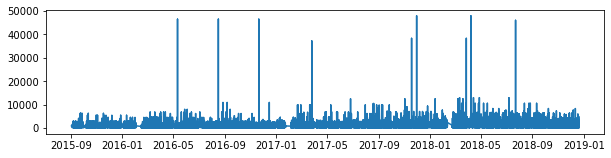

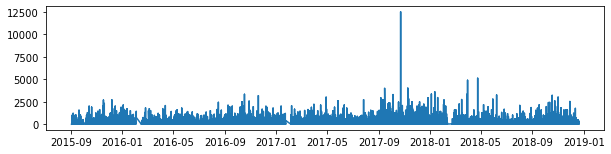

In [21]:
plt.figure(figsize=(10,5))
print(df.item_price.describe())
plt.subplot(1,2,1)
plt.plot(df['order_date'],df['item_price'])
# plt.figure(figsize=(10,5))
print(df.ord_qty.describe())
plt.subplot(1,2,2)
plt.plot(df['order_date'],df['ord_qty'])
plt.show()

## 删除异常值

箱线法去值，上须Q3 + 1.5*（Q3-Q1），下须Q1-1.5*(Q3-Q1)，超过上须或者低于下须的数据点都可以认为是异常值。

Q1 25%分位点 下四分位点
Q3 75%分位点 上四分位点

大量数据，所以做删除处理

min          1.000000
25%        597.000000
50%        880.280000
75%       1291.000000
max      47911.000000

min          1.000000
25%         10.000000
50%         29.000000
75%        101.000000
max      12480.000000

In [17]:
价格上须 = 1291 - 1.5*(1291-597)
价格下须 = 597 + 1.5*(1291-597)
print(价格上须,价格下须)

250.0 1638.0


In [13]:
交易上须 = 101 - 0.5*(101-10)
交易下须 = 10 + 0.5*(101-10)
print(交易上须,交易下须)

55.5 55.5


In [55]:
p = df['item_price']
q = df['ord_qty']

In [24]:
print(len(p),len(q))

59769 59769


In [56]:
p

0        1005.0
1        1420.0
2         978.0
3         864.0
4         274.0
          ...  
59764     799.0
59765     327.0
59766    1006.0
59767          
59768    1103.0
Name: item_price, Length: 59769, dtype: object

In [65]:
for i in range(len(p)):
    if p['item_price'][i] < 250.0 or p['item_price'][i] > 1638.0:
        print(p[i])
        p[i] = ' '
    i = i + 1
# print(p.head(10),len(p))

TypeError: '<' not supported between instances of 'str' and 'float'

In [28]:
p.to_excel('./看看多少空值.xlsx')
# 有10456（5）个空值

In [42]:
p.isnull().sum(axis = 0)

0

0        1005.0
1        1420.0
2         978.0
3         864.0
4         274.0
          ...  
59764     799.0
59765     327.0
59766    1006.0
59767          
59768    1103.0
Name: item_price, Length: 59769, dtype: object

TypeError: '<' not supported between instances of 'str' and 'float'

In [32]:
p

0        1005.0
1        1420.0
2         978.0
3         864.0
4         274.0
          ...  
59764     799.0
59765     327.0
59766    1006.0
59767          
59768    1103.0
Name: item_price, Length: 59769, dtype: object

In [15]:
dirc = {'offline':0,'online':1}
df['sales_chan_name'].replace(dirc,inplace = True)

In [16]:
df['sales_chan_name'].value_counts()

0    44084
1    15685
Name: sales_chan_name, dtype: int64

In [17]:
df.value_counts() # 竟然有重复数据，藏的够深

order_date  sales_region_code  item_code  first_cate_code  second_cate_code  sales_chan_name  item_price  ord_qty
2017/11/3   102                20135      303              401               0                859.0       3          2
2018/11/9   103                20661      302              408               0                926.0       10         2
2018/9/28   103                20531      307              403               0                1239.0      18         2
2015/10/10  101                20007      305              412               0                87.0        203        1
2018/10/10  103                21819      306              402               0                330.0       2          1
                                                                                                                    ..
2017/10/28  101                20433      305              412               0                1813.0      8          1
                               20459      305        

In [18]:
df.drop_duplicates(subset=None,keep = 'first',inplace = True)

In [19]:
df.value_counts()

order_date  sales_region_code  item_code  first_cate_code  second_cate_code  sales_chan_name  item_price  ord_qty
2015/10/10  101                20007      305              412               0                87.0        203        1
2018/10/10  103                21978      307              403               0                403.0       52         1
                               20661      302              408               0                929.0       19         1
                                                                                              939.0       20         1
                               20712      306              407               0                831.0       11         1
                                                                                                                    ..
2017/10/28  101                20433      305              412               0                1813.0      8          1
                               20459      305        

In [68]:
df[('item_price','ord_qty')].describe()

KeyError: ('item_price', 'ord_qty')

### 做一个价格和交易量的线性回归

## —————交易价格和交易量的关系——————

## ————地区和交易方式的关系—————

## ————商品大类和交易方式的关系————